In [1]:
%matplotlib inline
import importlib
import patch
import lda_utils
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import os
import scipy.io
import plot_utils

importlib.reload(patch)
importlib.reload(lda_utils)

TOPICS = 102
COLOR_WORDS = 500
SIFT_WORDS = 300
HISTOGRAM_BINS = 500
WINDOW_SIZE = 10
K = 1

if not os.path.exists(f"saved/"):
    os.mkdir(f"saved/")
if not os.path.exists("saved/color"):
    os.mkdir("saved/color")
if not os.path.exists("saved/hist"):
    os.mkdir("saved/hist")
if not os.path.exists("saved/models"):
    os.mkdir("saved/models")
if not os.path.exists("saved/quantized"):
    os.mkdir("saved/quantized")
if not os.path.exists("saved/sift"):
    os.mkdir("saved/sift")
os.makedirs(f"figures/flowers/{K}", exist_ok=True)

COLOR_VOCABULARY_FILE = os.path.join("saved/color/", f"color_vocab_{COLOR_WORDS}.pkl")
HISTOGRAM_VOCABULARY_FILE = os.path.join("saved/hist/", f"histogram_vocab_{HISTOGRAM_BINS}.pkl")
NO_SIFT_MODEL_FILE = os.path.join("saved/models/", f"no_sift_model_{COLOR_WORDS}_{HISTOGRAM_BINS}_{TOPICS}.pkl")
QUANTIZED_FILE = os.path.join("saved/quantized/", f"image_quantized_{COLOR_WORDS}_{HISTOGRAM_BINS}.pkl")
RUN_FIGURE_PATH = os.path.join(f"figures/flowers/{K}")
SIFT_FILE = os.path.join("saved/sift/", f"sift_quantized_{SIFT_WORDS}.pkl")
SIFT_QUANTIZATION = os.path.join("saved/quantized/", f"image_sift_quantized_{SIFT_WORDS}.pkl")
SIFT_ONLY_MODEL_FILE = os.path.join("saved/models/",
                                    f"sift_only_model_{SIFT_WORDS}_{TOPICS}.pkl")

In [2]:
images = patch.load_batch_images(0)

mat = scipy.io.loadmat('image_labels.mat')
labels = mat['labels'].flatten()
possible_topics = np.arange(TOPICS)
patch.compute_entropy(labels, TOPICS)

6.490071512794474

In [3]:
if not os.path.exists(COLOR_VOCABULARY_FILE):
    color_patches = [patch.get_random_patch(images[i], 3) for i in range(len(images))]
    colors = np.concatenate([patch.reshape(-1, 3) for patch in color_patches])
    color_vocabulary = patch.cluster(colors, COLOR_WORDS)
    with open(COLOR_VOCABULARY_FILE, 'wb+') as f:
        pkl.dump(color_vocabulary, f)
else:
    with open(COLOR_VOCABULARY_FILE, 'rb') as f:
        color_vocabulary = pkl.load(f)

In [4]:
bins = patch.get_bins(COLOR_WORDS)
if not os.path.exists(HISTOGRAM_VOCABULARY_FILE):
    histograms = []
    for i in range(len(images)):
        for p in patch.get_random_patch(images[i], WINDOW_SIZE, count=10):
            hist, _ = patch.get_histogram(color_vocabulary.predict(p.reshape(-1, 3)), bins)
            histograms.append(hist)
    histogram_cluster = patch.cluster(histograms, HISTOGRAM_BINS)
    with open(HISTOGRAM_VOCABULARY_FILE, 'wb+') as f:
        pkl.dump(histogram_cluster, f)
else:
    with open(HISTOGRAM_VOCABULARY_FILE, 'rb') as f:
        histogram_cluster = pkl.load(f)

In [5]:
if not os.path.exists(QUANTIZED_FILE):
    quantized_histograms = patch.get_histograms(images, color_vocabulary, histogram_cluster, COLOR_WORDS,
                                                HISTOGRAM_BINS, WINDOW_SIZE)
    with open(QUANTIZED_FILE, 'wb+') as f:
        pkl.dump(quantized_histograms, f)
else:
    with open(QUANTIZED_FILE, 'rb') as f:
        quantized_histograms = pkl.load(f)

In [6]:
from sklearn.decomposition import LatentDirichletAllocation

model = LatentDirichletAllocation(TOPICS)

In [7]:
if not os.path.exists(NO_SIFT_MODEL_FILE):
    model.fit(quantized_histograms)
    with open(NO_SIFT_MODEL_FILE, 'wb+') as f:
        pkl.dump(model, f)
else:
    with open(NO_SIFT_MODEL_FILE, 'rb') as f:
        model = pkl.load(f)

In [153]:
topics = np.argmax(model.transform(quantized_histograms), axis=1)

In [154]:
possible_topics = np.arange(np.max(labels))
possible = [np.where(topics == i)[0] for i in range(TOPICS)]

In [161]:
importlib.reload(plot_utils)
entropy = plot_utils.plot_histograms(TOPICS, possible, possible_topics, labels, RUN_FIGURE_PATH, "histogram")

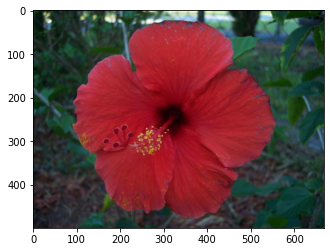

In [162]:
plt.imshow(images[possible[9][3]])

In [177]:
np.mean(entropy)

4.209474400714569

In [180]:
importlib.reload(plot_utils)
for captured_topic in range(TOPICS):
    topic_images = []
    for _ in possible[captured_topic]:
        topic_images.append(images[_])
        if len(topic_images) > 10:
            break
    plot_utils.plot_topic(topic_images, RUN_FIGURE_PATH, "histogram", captured_topic)
    plt.close()

In [183]:
print(len(images))

8189


In [186]:
# go for SIFT FEATURES
import random

if not os.path.exists(SIFT_FILE):
    features = []
    sampled_images = sorted(random.sample([i for i in range(len(images))], k=len(images) // 8))
    for i in sampled_images:
        feature = patch.get_sift(images[i])[1]
        if feature is None:
            continue
        indexes = random.sample(list(range(len(feature))), k=min(10, len(feature)))
        features.extend([f for f in feature[indexes]])
    sift_cluster = patch.cluster(features, SIFT_WORDS)
    with open(SIFT_FILE, 'wb+') as f:
        pkl.dump(sift_cluster, f)
else:
    with open(SIFT_FILE, 'rb') as f:
        sift_cluster = pkl.load(f)


In [188]:
sift_bins = patch.get_bins(SIFT_WORDS)
if not os.path.exists(SIFT_QUANTIZATION):
    quantized_sift = []
    for _, image in enumerate(images):
        feature = patch.get_sift(image)[1]
        if feature is None:
            quantized_sift.append(np.zeros(sift_bins.shape[0] - 1))
            continue
        h = np.histogram(sift_cluster.predict(feature.astype(np.double)), bins=sift_bins)[0]
        quantized_sift.append(h)
    quantized_sift = np.stack(quantized_sift)
    with open(SIFT_QUANTIZATION, 'wb+') as f:
        pkl.dump(quantized_sift, f)
else:
    with open(SIFT_QUANTIZATION, 'rb') as f:
        quantized_sift = pkl.load(f)

In [191]:
import gc
gc.collect(0)
gc.collect(1)
gc.collect(2)

0

In [193]:
sift_only_model = LatentDirichletAllocation(TOPICS)
if not os.path.exists(SIFT_ONLY_MODEL_FILE):
    sift_only_model.fit(quantized_sift)
    with open(SIFT_ONLY_MODEL_FILE, "wb+") as f:
        pkl.dump(sift_only_model, f)
else:
    with open(SIFT_ONLY_MODEL_FILE, 'rb') as f:
        sift_only_model = pkl.load(f)

In [194]:
sift_only_topics = np.argmax(sift_only_model.transform(quantized_sift), axis=1)
possible = [np.where(sift_only_topics == i)[0] for i in range(TOPICS)]
for captured_topic in range(TOPICS):
    topic_images = []
    for _ in possible[captured_topic]:
        topic_images.append(images[_])
        if len(topic_images) > 10:
            break
    plot_utils.plot_topic(topic_images, RUN_FIGURE_PATH, "sift_only", captured_topic)
    plt.close()

In [196]:
importlib.reload(plot_utils)
sift_only_entropy = plot_utils.plot_histograms(TOPICS, possible, possible_topics, labels, RUN_FIGURE_PATH, "sift_only")

In [198]:
print(np.nanmean(sift_only_entropy))

3.8767987513067808
